In [ ]:
# Install required libraries
!pip install transformers  # Installs the transformers library for NLP models
!pip install imageio       # Installs imageio to handle image files (e.g., GIFs)
!pip install gtts          # Installs Google Text-to-Speech API for text-to-speech
!pip install bert-score    # Installs the BERTScore metric library for evaluation
!pip install nltk          # Installs the NLTK library for natural language processing tasks
!pip install rouge-score   # Installs the Rouge score package for evaluation metrics

import os
import json
import random
import requests
import imageio
from PIL import Image
from io import BytesIO
import torch
from transformers import (
    BlipProcessor,
    BlipForConditionalGeneration,
    T5Tokenizer,
    T5ForConditionalGeneration,
    AdamW
)
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
import nltk
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu
# from nltk.translate.meteor_score import meteor_score
from rouge_score import rouge_scorer
from bert_score import score as bert_score_fn
import numpy as np

# Download NLTK data
nltk.download('wordnet')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=b0abd92c27af592126f598e236c66c197e64b11b92ac2650105910a37fbda83f
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import os
import json
import random

# Define paths
metadata_file = 'datafile.json'  # Path to your metadata file that contains GIF information
gifs_dir = 'gifs_temp'           # Directory to temporarily store GIFs

# Create temporary GIFs directory if it doesn't exist
os.makedirs(gifs_dir, exist_ok=True)

# Load metadata from the metadata file
with open(metadata_file, 'r') as f:
    metadata = json.load(f)

# Check if the dataset contains at least 100 GIFs, if not raise an error
if len(metadata) < 1500:
    raise ValueError("The metadata file contains fewer than 100 GIFs.")

# Randomly select 1500 GIFs from the metadata for processing
selected_gifs = random.sample(metadata, 1500)

# Output the number of selected GIFs
print(f"Selected {len(selected_gifs)} random GIFs for processing.")


In [ ]:
import time

# Enhanced download function with retries
def download_gif(url, save_path, max_retries=3, backoff_factor=2):
    for attempt in range(1, max_retries + 1):
        try:
            headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64)"
            }
            response = requests.get(url, headers=headers, timeout=10)
            response.raise_for_status()
            with open(save_path, 'wb') as f:
                f.write(response.content)
            print(f"Downloaded: {save_path}")
            return True
        except requests.exceptions.HTTPError as http_err:
            print(f"HTTP error: {http_err} - Attempt {attempt}")
            if response.status_code == 404:
                break
        except requests.exceptions.RequestException as req_err:
            print(f"Request error: {req_err} - Attempt {attempt}")
        except Exception as e:
            print(f"Unexpected error: {e} - Attempt {attempt}")
        # Exponential backoff
        time.sleep(backoff_factor ** attempt)
    print(f"Failed to download {url}")
    return False

# Function to extract and preprocess frames from GIF
def extract_frames(gif_path, num_frames=10, frame_size=(256, 256)):
    try:
        gif = imageio.mimread(gif_path)
        total_frames = len(gif)

        if total_frames == 0:
            raise ValueError("No frames found in GIF.")

        interval = max(total_frames // num_frames, 1)
        selected_frames = [gif[i] for i in range(0, total_frames, interval)][:num_frames]

        processed_frames = []
        for frame in selected_frames:
            img = Image.fromarray(frame)
            if img.mode != 'RGB':
                img = img.convert('RGB')
            img_resized = img.resize(frame_size)
            processed_frames.append(np.array(img_resized))

        # Pad with the last frame or zeros
        while len(processed_frames) < num_frames:
            processed_frames.append(processed_frames[-1] if processed_frames else np.zeros((frame_size[0], frame_size[1], 3), dtype=np.uint8))

        return processed_frames

    except Exception as e:
        print(f"Failed to extract frames from {gif_path}: {e}")
        return []

# Function to delete GIF after processing
def delete_gif(gif_path):
    try:
        os.remove(gif_path)
        print(f"Deleted: {gif_path}")
    except Exception as e:
        print(f"Failed to delete {gif_path}: {e}")


In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import os

# Initialize lists to store data
target_frames = []
target_texts = []

# Process each GIF
for gif in tqdm(selected_gifs, desc="Processing GIFs"):
    gif_id = gif.get('id')
    url = gif.get('url')
    reference_description = gif.get('description')

    # Validate GIF entry
    if not gif_id or not url or not reference_description:
        print(f"Invalid GIF entry: {gif}")
        continue

    # Define local path to save the GIF temporarily
    gif_filename = f"{gif_id}.gif"
    gif_path = os.path.join(gifs_dir, gif_filename)

    # Download the GIF
    success = download_gif(url, gif_path)
    if not success:
        print(f"Skipping GIF {gif_id} due to download failure.")
        continue

    # Extract frames
    selected_frames = extract_frames(gif_path, num_frames=5)

    # Validate frame extraction
    if not selected_frames:
        print(f"No frames extracted for {gif_id}. Skipping.")
        delete_gif(gif_path)
        continue

    # Append the extracted frames and corresponding text
    target_frames.append(selected_frames)
    target_texts.append(reference_description)

    # Delete the downloaded GIF
    delete_gif(gif_path)


In [ ]:
import torch
import numpy as np

# Assume target_frames is the list of GIFs, where each GIF is a list of frames (each frame is a numpy array)
processed_gifs = []

for gif in target_frames:
    # Convert list of frames (numpy arrays) into a single numpy array
    frames_array = np.array(gif)  # Convert to a single numpy array
    # Now convert the numpy array to a PyTorch tensor
    frames_tensor = torch.tensor(frames_array)  # Convert to a PyTorch tensor

    # Append the processed tensor to the list
    processed_gifs.append(frames_tensor)

# Now processed_gifs is a list of tensors, where each tensor represents a GIF


Saving the data

In [ ]:
import torch

# Move all tensors in processed_gifs to CPU
processed_gifs_cpu = [gif.cpu() for gif in processed_gifs]

# Create a dictionary to hold both lists
data = {
    'processed_gifs': processed_gifs_cpu,
    'target_texts': target_texts
}

# Save the dictionary to a file
torch.save(data, 'data.pth')

print("Data has been saved successfully as 'data.pth'.")


Loading data when needed

In [ ]:
import torch

# Load the saved data from the local file
data = torch.load('data.pth', map_location=torch.device('cpu'))  # Change 'cpu' to 'cuda' if loading on GPU

processed_gifs = data['processed_gifs']
target_texts = data['target_texts']

print("Data has been loaded successfully from 'data.pth'.")


<ipython-input-10-1e2442dfdc7f>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('data.pth', map_location=torch.device('cpu'))  # Change 'cpu' to 'cuda' if

Data has been loaded successfully from 'data.pth'.


In [ ]:
# Initialize BLIP processor and model
blip_processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
blip_model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to('cuda' if torch.cuda.is_available() else 'cpu')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.56k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

In [ ]:
layers = ["layer.10", "layer.11", "layers.10", "layers.11"]
for name, param in blip_model.named_parameters():
  param.requires_grad = False
  for layer in layers:
    if layer in name:
      param.requires_grad = True
      break


In [ ]:
for name, param in blip_model.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"Layer: {name}, Status: {status}")

Layer: vision_model.embeddings.class_embedding, Status: Frozen
Layer: vision_model.embeddings.position_embedding, Status: Frozen
Layer: vision_model.embeddings.patch_embedding.weight, Status: Frozen
Layer: vision_model.embeddings.patch_embedding.bias, Status: Frozen
Layer: vision_model.encoder.layers.0.self_attn.qkv.weight, Status: Frozen
Layer: vision_model.encoder.layers.0.self_attn.qkv.bias, Status: Frozen
Layer: vision_model.encoder.layers.0.self_attn.projection.weight, Status: Frozen
Layer: vision_model.encoder.layers.0.self_attn.projection.bias, Status: Frozen
Layer: vision_model.encoder.layers.0.layer_norm1.weight, Status: Frozen
Layer: vision_model.encoder.layers.0.layer_norm1.bias, Status: Frozen
Layer: vision_model.encoder.layers.0.mlp.fc1.weight, Status: Frozen
Layer: vision_model.encoder.layers.0.mlp.fc1.bias, Status: Frozen
Layer: vision_model.encoder.layers.0.mlp.fc2.weight, Status: Frozen
Layer: vision_model.encoder.layers.0.mlp.fc2.bias, Status: Frozen
Layer: vision_mod

In [ ]:
# Initialize T5 tokenizer and model
t5_tokenizer = T5Tokenizer.from_pretrained('t5-base')
t5_model = T5ForConditionalGeneration.from_pretrained('t5-base').to('cuda' if torch.cuda.is_available() else 'cpu')


spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


model.safetensors:   0%|          | 0.00/892M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

In [ ]:
for name, parameter in t5_model.named_parameters():
  if "encoder.block" in name:
    index = name.split(".")[2]
    if int(index) < 10:
      parameter.requires_grad = False
    else:
      parameter.requires_grad = True


for name, parameter in t5_model.named_parameters():
  if "decoder.block" in name:
    index = name.split(".")[2]
    if int(index) < 9:
      parameter.requires_grad = False
    else:
      parameter.requires_grad = True

In [ ]:
for name, parameter in t5_model.named_parameters():
  status = "Trainable" if parameter.requires_grad else "Frozen"
  print(f"Layer: {name}, Status: {status}")

Layer: shared.weight, Status: Trainable
Layer: encoder.block.0.layer.0.SelfAttention.q.weight, Status: Frozen
Layer: encoder.block.0.layer.0.SelfAttention.k.weight, Status: Frozen
Layer: encoder.block.0.layer.0.SelfAttention.v.weight, Status: Frozen
Layer: encoder.block.0.layer.0.SelfAttention.o.weight, Status: Frozen
Layer: encoder.block.0.layer.0.SelfAttention.relative_attention_bias.weight, Status: Frozen
Layer: encoder.block.0.layer.0.layer_norm.weight, Status: Frozen
Layer: encoder.block.0.layer.1.DenseReluDense.wi.weight, Status: Frozen
Layer: encoder.block.0.layer.1.DenseReluDense.wo.weight, Status: Frozen
Layer: encoder.block.0.layer.1.layer_norm.weight, Status: Frozen
Layer: encoder.block.1.layer.0.SelfAttention.q.weight, Status: Frozen
Layer: encoder.block.1.layer.0.SelfAttention.k.weight, Status: Frozen
Layer: encoder.block.1.layer.0.SelfAttention.v.weight, Status: Frozen
Layer: encoder.block.1.layer.0.SelfAttention.o.weight, Status: Frozen
Layer: encoder.block.1.layer.0.lay

In [ ]:
import torch
import numpy as np
from torch.utils.data import Dataset

class GifAggregationDataset(Dataset):
    def __init__(self, frames_list, targets, tokenizer, max_target_length=150):
        """
        frames_list: A list of lists containing frames (as tensors or numpy arrays) for each GIF.
        targets: The ground truth captions for each GIF.
        tokenizer: Tokenizer for T5 to encode the target captions.
        max_target_length: Maximum length for the target text sequences.
        """
        self.frames_list = frames_list  # List of frame sequences (e.g., list of tensors for each GIF)
        self.targets = targets  # Ground truth captions for each GIF
        self.tokenizer = tokenizer
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.frames_list)

    def __getitem__(self, idx):
        # Get frames and target for the given index
        frames = self.frames_list[idx]  # List or tensor of frames for a single GIF
        target_text = self.targets[idx]

        # Ensure frames are in the correct shape (num_frames, height, width, channels)
        if isinstance(frames, list):
            # Convert list of numpy arrays to a single numpy array, if necessary
            frames = np.array(frames)

        # If frames are numpy arrays, convert to torch tensor and make sure dimensions are correct
        if isinstance(frames, np.ndarray):
            frames = torch.tensor(frames, dtype=torch.float32)  # Convert to float32 tensor for PyTorch

        # Reshape or permute frames to ensure the shape is (num_frames, height, width, channels)
        if frames.ndim == 4 and frames.shape[-1] == 3:
            # Shape is (num_frames, height, width, channels), which is correct for PIL conversion
            pass
        elif frames.ndim == 4 and frames.shape[1] == 3:
            # If frames have shape (num_frames, channels, height, width), change to (num_frames, height, width, channels)
            frames = frames.permute(0, 2, 3, 1)  # (N, C, H, W) -> (N, H, W, C)

        # Tokenize the target caption (ground-truth description)
        target_encoding = self.tokenizer(
            target_text,
            padding='max_length',
            truncation=True,
            max_length=self.max_target_length,
            return_tensors="pt"
        )

        # Replace padding token ID's of the labels by -100 to ignore them in the loss
        labels = target_encoding.input_ids.squeeze()
        labels[labels == self.tokenizer.pad_token_id] = -100

        return {
            'frames': frames,  # Provide frames directly in tensor format (num_frames, height, width, channels)
            'labels': labels,  # Provide tokenized ground truth captions for T5
            'reference_description': target_text
        }


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from transformers import T5Tokenizer
from torch.utils.data import DataLoader, random_split

# Setup the models in training mode
blip_model.train()  # BLIP is now being trained, so it's in training mode
t5_model.train()    # T5 is also being trained

# Define optimizers for BLIP and T5
blip_params = filter(lambda p: p.requires_grad, blip_model.parameters())
t5_params = filter(lambda p: p.requires_grad, t5_model.parameters())

blip_optimizer = optim.AdamW(blip_params, lr=0.00005)  # Lower learning rate since we're training both
t5_optimizer = optim.AdamW(t5_params, lr=0.00005)

# Define the loss function for T5
criterion = nn.CrossEntropyLoss(ignore_index=-100)

In [ ]:
# Prepare DataLoader (frames and target descriptions)

aggregation_dataset = GifAggregationDataset(
    frames_list=processed_gifs,   # This should be the frames for each GIF (as a list of tensors)
    targets=target_texts,      # The ground truth aggregated captions
    tokenizer=t5_tokenizer,    # Tokenizer for processing the target texts
    max_target_length=150      # Max length for target captions
)

# Split dataset into training and validation sets (80-20 split)
train_size = int(0.8 * len(aggregation_dataset))
val_size = len(aggregation_dataset) - train_size
train_dataset, val_dataset = random_split(aggregation_dataset, [train_size, val_size])

# Create DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    batch_size=16,  # Define the batch size that fits your GPU memory
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=16,  # Define the batch size for validation
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


Function to evaluate the model in the training phase

In [ ]:
import torch
from tqdm import tqdm
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
import bert_score
from PIL import Image

def evaluate_model_training(blip_model, t5_model, blip_processor, tokenizer, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    blip_model.eval()  # Set BLIP to evaluation mode
    t5_model.eval()    # Set T5 to evaluation mode

    # Metrics containers
    all_references = []
    all_candidates = []
    rougeL_scores = []


    # ROUGE scorer initialization
    scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)


    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Step 1: Prepare frames for BLIP
            frames = batch['frames']  # Assuming shape [batch_size, num_frames, C, H, W] or [batch_size, num_frames, H, W, C]
            reference_descriptions = batch['reference_description']  # List of reference captions

            batch_size, num_frames = frames.shape[0], frames.shape[1]

            frame_captions = []

            for i in range(batch_size):
                single_captions = []
                for j in range(num_frames):
                    frame = frames[i, j]  # Shape depends on data format

                    # Determine frame shape and permute if necessary
                    if frame.ndim == 3:
                        # Possible shapes:
                        # [C, H, W] or [H, W, C]
                        if frame.shape[0] == 3:
                            # [C, H, W] -> [H, W, C]
                            frame = frame.permute(1, 2, 0)
                        # Else assume [H, W, C], no change needed
                    else:
                        raise ValueError(f"Unexpected frame shape: {frame.shape}")

                    # Convert to CPU and numpy
                    frame_np = frame.cpu().numpy().astype('uint8')  # Ensure dtype is uint8

                    # Convert to PIL Image
                    try:
                        img = Image.fromarray(frame_np).convert('RGB')
                    except Exception as e:
                        print(f"Error converting frame to image: {e}")
                        continue  # Skip this frame

                    # Generate caption using BLIP
                    inputs = blip_processor(img, return_tensors="pt").to(device)
                    outputs = blip_model.generate(**inputs, max_length=150)  # Limit caption length
                    caption = blip_processor.decode(outputs[0], skip_special_tokens=True)
                    single_captions.append(caption)

                # Concatenate captions for the current example
                concatenated_caption = " ".join(single_captions)
                frame_captions.append(concatenated_caption)

            # Step 2: Tokenize the concatenated captions as a batch
            max_length = 128  # Adjust based on GPU capacity and desired sequence length
            t5_inputs = tokenizer(
                frame_captions,  # List of concatenated captions, one per example in the batch
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            ).to(device)

            # Step 3: Generate predictions using T5
            outputs = t5_model.generate(
                input_ids=t5_inputs.input_ids,
                attention_mask=t5_inputs.attention_mask,
                max_length=150,
                num_beams=4,
                early_stopping=True
            )

            # Step 4: Decode predictions
            predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            # Step 5: Evaluate the predictions
            for ref, pred in zip(reference_descriptions, predictions):
                ref_tokens = ref.split()
                pred_tokens = pred.split()

                # Append references and predictions for BLEU
                all_references.append([ref_tokens])
                all_candidates.append(pred_tokens)

                # ROUGE scores calculation
                scores = scorer.score(ref, pred)
                rougeL_scores.append(scores['rougeL'].fmeasure)

    # Calculate average ROUGE scores
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0


    # Compile metrics
    metrics = {
        'ROUGE-L': avg_rougeL,
    }

    return metrics


Function to evaluate the models when they finished training phase

In [ ]:
import torch
from tqdm import tqdm
from rouge_score import rouge_scorer
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
import bert_score
from PIL import Image

def evaluate_model(blip_model, t5_model, blip_processor, tokenizer, dataloader, device='cuda' if torch.cuda.is_available() else 'cpu'):
    blip_model.eval()  # Set BLIP to evaluation mode
    t5_model.eval()    # Set T5 to evaluation mode

    # Metrics containers
    all_references = []
    all_candidates = []
    rouge1_scores = []
    rouge2_scores = []
    rougeL_scores = []
    # meteor_scores_list = []

    # ROUGE scorer initialization
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # BERTScore
    bert_score_fn = bert_score.score

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            # Step 1: Prepare frames for BLIP
            frames = batch['frames']  # Assuming shape [batch_size, num_frames, C, H, W] or [batch_size, num_frames, H, W, C]
            reference_descriptions = batch['reference_description']  # List of reference captions

            batch_size, num_frames = frames.shape[0], frames.shape[1]

            frame_captions = []

            for i in range(batch_size):
                single_captions = []
                for j in range(num_frames):
                    frame = frames[i, j]  # Shape depends on data format

                    # Determine frame shape and permute if necessary
                    if frame.ndim == 3:
                        # Possible shapes:
                        # [C, H, W] or [H, W, C]
                        if frame.shape[0] == 3:
                            # [C, H, W] -> [H, W, C]
                            frame = frame.permute(1, 2, 0)
                        # Else assume [H, W, C], no change needed
                    else:
                        raise ValueError(f"Unexpected frame shape: {frame.shape}")

                    # Convert to CPU and numpy
                    frame_np = frame.cpu().numpy().astype('uint8')  # Ensure dtype is uint8

                    # Convert to PIL Image
                    try:
                        img = Image.fromarray(frame_np).convert('RGB')
                    except Exception as e:
                        print(f"Error converting frame to image: {e}")
                        continue  # Skip this frame

                    # Generate caption using BLIP
                    inputs = blip_processor(img, return_tensors="pt").to(device)
                    outputs = blip_model.generate(**inputs, max_length=50)  # Limit caption length
                    caption = blip_processor.decode(outputs[0], skip_special_tokens=True)
                    single_captions.append(caption)

                # Concatenate captions for the current example
                concatenated_caption = " ".join(single_captions)
                frame_captions.append(concatenated_caption)

            # Step 2: Tokenize the concatenated captions as a batch
            max_length = 128  # Adjust based on GPU capacity and desired sequence length
            t5_inputs = tokenizer(
                frame_captions,  # List of concatenated captions, one per example in the batch
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors="pt"
            ).to(device)

            # Step 3: Generate predictions using T5
            outputs = t5_model.generate(
                input_ids=t5_inputs.input_ids,
                attention_mask=t5_inputs.attention_mask,
                max_length=150,
                num_beams=4,
                early_stopping=True
            )

            # Step 4: Decode predictions
            predictions = tokenizer.batch_decode(outputs, skip_special_tokens=True)

            # Step 5: Evaluate the predictions
            for ref, pred in zip(reference_descriptions, predictions):
                ref_tokens = ref.split()
                pred_tokens = pred.split()

                # Append references and predictions for BLEU
                all_references.append([ref_tokens])
                all_candidates.append(pred_tokens)

                # ROUGE scores calculation
                scores = scorer.score(ref, pred)
                rouge1_scores.append(scores['rouge1'].fmeasure)
                rouge2_scores.append(scores['rouge2'].fmeasure)
                rougeL_scores.append(scores['rougeL'].fmeasure)

                # METEOR score calculation
                # meteor = meteor_score([ref_tokens], pred_tokens)
                # meteor_scores_list.append(meteor)

    # Calculate BLEU score
    bleu = corpus_bleu(all_references, all_candidates)

    # Calculate average ROUGE scores
    avg_rouge1 = sum(rouge1_scores) / len(rouge1_scores) if rouge1_scores else 0
    avg_rouge2 = sum(rouge2_scores) / len(rouge2_scores) if rouge2_scores else 0
    avg_rougeL = sum(rougeL_scores) / len(rougeL_scores) if rougeL_scores else 0

    # Calculate average METEOR score
    # avg_meteor = sum(meteor_scores_list) / len(meteor_scores_list) if meteor_scores_list else 0

    # Calculate BERT Score
    P, R, F1 = bert_score_fn(
        [' '.join(cand) for cand in all_candidates],
        [' '.join(ref[0]) for ref in all_references],
        lang='en',
        verbose=True)
    avg_bert_f1 = F1.mean().item()

    # Compile metrics
    metrics = {
        'BLEU': bleu,
        'ROUGE-1': avg_rouge1,
        'ROUGE-2': avg_rouge2,
        'ROUGE-L': avg_rougeL,
        # 'METEOR': avg_meteor,
        'BERT_F1': avg_bert_f1
    }

    return metrics


In [19]:
import torch
from torch.optim import AdamW
from PIL import Image
from transformers import T5Tokenizer
import torch.nn.functional as F

# Set the models to training mode
t5_model.train()
blip_model.train()

# Filter parameters that require gradients for BLIP and T5 models
blip_params = filter(lambda p: p.requires_grad, blip_model.parameters())
t5_params = filter(lambda p: p.requires_grad, t5_model.parameters())

# Define the optimizer using AdamW with appropriate learning rates
blip_optimizer = AdamW(blip_params, lr=1e-4)
t5_optimizer = AdamW(t5_params, lr=1e-4)

# Training Loop
epochs = 7
device = 'cuda' if torch.cuda.is_available() else 'cpu'
blip_model.to(device)
t5_model.to(device)

# Lists to store metrics over epochs
training_losses = []
#bleu_scores = []
#rouge1_scores = []
#rouge2_scores = []
rougeL_scores = []
# meteor_scores = []
#bert_f1_scores = []

# Training both BLIP and T5 using the DataLoader
for epoch in range(epochs):
    t5_model.train()
    blip_model.train()

    # Initialize average loss for tracking epoch training loss
    epoch_loss = 0.0
    num_batches = 0

    for batch in train_dataloader:
        # Step 1: Prepare data for BLIP
        frames = batch['frames']  # Get frames for the current batch
        # Assuming frames is a list of shape [batch_size, num_frames, height, width, channels]
        batch_size = frames.size(0)
        frames = frames.to(device)  # Move frames to GPU if available

        # Zero gradients for both optimizers
        blip_optimizer.zero_grad()
        t5_optimizer.zero_grad()

        # Step 2: Generate frame-level captions with BLIP
        frame_captions = []
        for i in range(batch_size):
            single_captions = []
            for single_frame in frames[i]:
                # Convert frame to a PIL image and generate caption using BLIP model
                img = Image.fromarray(single_frame.cpu().numpy().astype('uint8'), 'RGB')
                inputs = blip_processor(img, return_tensors="pt").to(device)

                # Set max_length explicitly for BLIP generation to avoid inconsistent lengths
                outputs = blip_model.generate(**inputs, max_length=200)  # Limit caption length to 150 tokens
                caption = blip_processor.decode(outputs[0], skip_special_tokens=True)
                single_captions.append(caption)
            # Concatenate captions for the current example
            concatenated_caption = " ".join(single_captions)
            frame_captions.append(concatenated_caption)

        # Step 3: Tokenize the concatenated captions as a batch
        max_length = 200  # Adjust as needed based on your GPU capacity
        t5_inputs = t5_tokenizer(
            frame_captions,  # List of concatenated captions, one per example in the batch
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        ).to(device)

        # Prepare labels
        labels = batch['labels'].to(device)
        labels = labels[:, :t5_inputs.input_ids.shape[-1]]  # Truncate labels if necessary

        # Pad labels to match input length using -100 to ignore during loss calculation
        labels = F.pad(
            labels,
            (0, max(0, t5_inputs.input_ids.shape[-1] - labels.shape[-1])),
            value=-100
        )

        # Ensure the attention mask is consistent
        t5_attention_mask = t5_inputs.attention_mask

        # Step 5: Forward pass through T5 model
        outputs = t5_model(
            input_ids=t5_inputs.input_ids,
            attention_mask=t5_attention_mask,
            labels=labels
        )
        loss = outputs.loss

        # Step 6: Backpropagation and optimizer step
        loss.backward()  # Compute gradients for both models (BLIP and T5)
        blip_optimizer.step()
        t5_optimizer.step()

        # Accumulate the loss for averaging
        epoch_loss += loss.item()
        num_batches += 1

        # Step 7: Print the training loss for the current iteration
        print(f"Epoch [{epoch + 1}/{epochs}], Batch Loss: {loss.item()}")

    # Calculate the average training loss for the epoch
    average_epoch_loss = epoch_loss / num_batches
    training_losses.append(average_epoch_loss)
    print(f"Epoch [{epoch + 1}/{epochs}], Average Training Loss: {average_epoch_loss}")

    # Evaluate after each epoch
    metrics = evaluate_model_training(blip_model, t5_model, blip_processor, t5_tokenizer, val_dataloader, device)
    #bleu_scores.append(metrics['BLEU'])
    #rouge1_scores.append(metrics['ROUGE-1'])
    #rouge2_scores.append(metrics['ROUGE-2'])
    rougeL_scores.append(metrics['ROUGE-L'])
    # meteor_scores.append(metrics['METEOR'])
    # bert_f1_scores.append(metrics['BERT_F1'])

    # Print evaluation metrics for each epoch
    print(f"Validation Metrics after Epoch {epoch+1}: {metrics}")

    # Clear GPU cache after each epoch to free up memory
    torch.cuda.empty_cache()


Epoch [1/7], Batch Loss: 2.792562484741211
Epoch [1/7], Batch Loss: 3.05653715133667
Epoch [1/7], Batch Loss: 2.8849689960479736
Epoch [1/7], Batch Loss: 2.9645094871520996
Epoch [1/7], Batch Loss: 2.6882576942443848
Epoch [1/7], Batch Loss: 2.5022499561309814
Epoch [1/7], Batch Loss: 2.851562261581421
Epoch [1/7], Batch Loss: 2.91620135307312
Epoch [1/7], Batch Loss: 3.1907904148101807
Epoch [1/7], Batch Loss: 2.9111499786376953
Epoch [1/7], Batch Loss: 3.0466115474700928
Epoch [1/7], Batch Loss: 2.8951869010925293
Epoch [1/7], Batch Loss: 2.815492868423462
Epoch [1/7], Batch Loss: 2.6365480422973633
Epoch [1/7], Batch Loss: 2.799355983734131
Epoch [1/7], Batch Loss: 2.536698579788208
Epoch [1/7], Batch Loss: 2.613626003265381
Epoch [1/7], Batch Loss: 2.661198377609253
Epoch [1/7], Batch Loss: 2.7486190795898438
Epoch [1/7], Batch Loss: 2.721141815185547
Epoch [1/7], Batch Loss: 2.695596933364868
Epoch [1/7], Batch Loss: 2.6508281230926514
Epoch [1/7], Batch Loss: 2.557412624359131
Ep

Evaluating: 100%|██████████| 19/19 [05:37<00:00, 17.78s/it]


Validation Metrics after Epoch 1: {'ROUGE-L': 0.3243333918983624}
Epoch [2/7], Batch Loss: 2.473907947540283
Epoch [2/7], Batch Loss: 2.302682638168335
Epoch [2/7], Batch Loss: 2.329249858856201
Epoch [2/7], Batch Loss: 2.5172479152679443
Epoch [2/7], Batch Loss: 2.761099100112915
Epoch [2/7], Batch Loss: 2.3488035202026367
Epoch [2/7], Batch Loss: 2.4597198963165283
Epoch [2/7], Batch Loss: 2.6647422313690186
Epoch [2/7], Batch Loss: 2.5523948669433594
Epoch [2/7], Batch Loss: 2.1182148456573486
Epoch [2/7], Batch Loss: 2.4329872131347656
Epoch [2/7], Batch Loss: 2.316796064376831
Epoch [2/7], Batch Loss: 2.259514808654785
Epoch [2/7], Batch Loss: 2.6163504123687744
Epoch [2/7], Batch Loss: 2.3733248710632324
Epoch [2/7], Batch Loss: 2.4834394454956055
Epoch [2/7], Batch Loss: 2.3729352951049805
Epoch [2/7], Batch Loss: 2.58955717086792
Epoch [2/7], Batch Loss: 2.56703782081604
Epoch [2/7], Batch Loss: 2.5039615631103516
Epoch [2/7], Batch Loss: 2.472188949584961
Epoch [2/7], Batch Lo

Evaluating: 100%|██████████| 19/19 [05:40<00:00, 17.94s/it]


Validation Metrics after Epoch 2: {'ROUGE-L': 0.344430507047284}
Epoch [3/7], Batch Loss: 2.1594936847686768
Epoch [3/7], Batch Loss: 2.2254562377929688
Epoch [3/7], Batch Loss: 2.238584041595459
Epoch [3/7], Batch Loss: 2.3106191158294678
Epoch [3/7], Batch Loss: 2.3417437076568604
Epoch [3/7], Batch Loss: 2.27418851852417
Epoch [3/7], Batch Loss: 2.168013572692871
Epoch [3/7], Batch Loss: 2.4113423824310303
Epoch [3/7], Batch Loss: 2.413123607635498
Epoch [3/7], Batch Loss: 2.1674985885620117
Epoch [3/7], Batch Loss: 2.2781403064727783
Epoch [3/7], Batch Loss: 2.450666666030884
Epoch [3/7], Batch Loss: 2.333395004272461
Epoch [3/7], Batch Loss: 2.5388786792755127
Epoch [3/7], Batch Loss: 2.3976004123687744
Epoch [3/7], Batch Loss: 2.227501392364502
Epoch [3/7], Batch Loss: 2.392740249633789
Epoch [3/7], Batch Loss: 2.5090410709381104
Epoch [3/7], Batch Loss: 2.302180051803589
Epoch [3/7], Batch Loss: 2.5127153396606445
Epoch [3/7], Batch Loss: 2.105900526046753
Epoch [3/7], Batch Los

Evaluating: 100%|██████████| 19/19 [05:39<00:00, 17.85s/it]


Validation Metrics after Epoch 3: {'ROUGE-L': 0.345049722565402}
Epoch [4/7], Batch Loss: 2.332324504852295
Epoch [4/7], Batch Loss: 1.9613622426986694
Epoch [4/7], Batch Loss: 2.4344804286956787
Epoch [4/7], Batch Loss: 2.2704036235809326
Epoch [4/7], Batch Loss: 2.047391653060913
Epoch [4/7], Batch Loss: 2.4810235500335693
Epoch [4/7], Batch Loss: 2.0178885459899902
Epoch [4/7], Batch Loss: 2.5367531776428223
Epoch [4/7], Batch Loss: 2.224294424057007
Epoch [4/7], Batch Loss: 2.3060758113861084
Epoch [4/7], Batch Loss: 1.9798797369003296
Epoch [4/7], Batch Loss: 2.010374069213867
Epoch [4/7], Batch Loss: 2.366204023361206
Epoch [4/7], Batch Loss: 2.5163962841033936
Epoch [4/7], Batch Loss: 2.3553290367126465
Epoch [4/7], Batch Loss: 2.0656449794769287
Epoch [4/7], Batch Loss: 2.4845731258392334
Epoch [4/7], Batch Loss: 2.170170783996582
Epoch [4/7], Batch Loss: 2.3512303829193115
Epoch [4/7], Batch Loss: 2.300783395767212
Epoch [4/7], Batch Loss: 2.099226951599121
Epoch [4/7], Batch 

Evaluating: 100%|██████████| 19/19 [05:44<00:00, 18.13s/it]


Validation Metrics after Epoch 4: {'ROUGE-L': 0.3317802685420676}
Epoch [5/7], Batch Loss: 2.312358856201172
Epoch [5/7], Batch Loss: 2.3025755882263184
Epoch [5/7], Batch Loss: 1.948441982269287
Epoch [5/7], Batch Loss: 2.246487617492676
Epoch [5/7], Batch Loss: 2.4745826721191406
Epoch [5/7], Batch Loss: 2.2634265422821045
Epoch [5/7], Batch Loss: 2.0459282398223877
Epoch [5/7], Batch Loss: 2.197880983352661
Epoch [5/7], Batch Loss: 2.2163000106811523
Epoch [5/7], Batch Loss: 2.130763292312622
Epoch [5/7], Batch Loss: 2.293497085571289
Epoch [5/7], Batch Loss: 2.124683380126953
Epoch [5/7], Batch Loss: 2.2604856491088867
Epoch [5/7], Batch Loss: 2.1804897785186768
Epoch [5/7], Batch Loss: 2.147610664367676
Epoch [5/7], Batch Loss: 2.0365312099456787
Epoch [5/7], Batch Loss: 2.1277987957000732
Epoch [5/7], Batch Loss: 2.0480313301086426
Epoch [5/7], Batch Loss: 1.9922146797180176
Epoch [5/7], Batch Loss: 2.1892406940460205
Epoch [5/7], Batch Loss: 2.080991744995117
Epoch [5/7], Batch 

Evaluating: 100%|██████████| 19/19 [05:38<00:00, 17.80s/it]


Validation Metrics after Epoch 5: {'ROUGE-L': 0.33798108652954467}
Epoch [6/7], Batch Loss: 2.0221457481384277
Epoch [6/7], Batch Loss: 1.918637752532959
Epoch [6/7], Batch Loss: 2.465228319168091


KeyboardInterrupt: 

In [27]:
rougeL_scores = [0.3243333918983624, 0.344430507047284, 0.345049722565402, 0.3317802685420676, 0.33798108652954467]
training_losses = [2.621926883061727, 2.4245523611704507, 2.32952486038208, 2.260512758890788, 2.192203664779663 ]

In [20]:
import torch

# Define local save paths
blip_save_path = 'blip_model.pth'
t5_save_path = 't5_model.pth'

# Save the state_dict of each model
torch.save(blip_model.state_dict(), blip_save_path)
torch.save(t5_model.state_dict(), t5_save_path)

print("Models have been saved locally.")


Models have been saved locally.


In [ ]:
# Evaluate after each epoch
metrics = evaluate_model_training(blip_model, t5_model, blip_processor, t5_tokenizer, train_dataloader, device)

# Print evaluation metrics for each epoch
print(f"Training Metric after Epoch {epoch+1}: {metrics}")

Evaluating:  93%|█████████▎| 70/75 [21:35<01:34, 18.85s/it]

In [24]:
# After training each epoch, evaluate the model on the validation set
metrics = evaluate_model(blip_model, t5_model, blip_processor, t5_tokenizer, val_dataloader, device)
print(f"Validation Metrics after Epoch {epoch+1}: {metrics}")


Evaluating: 100%|██████████| 19/19 [05:36<00:00, 17.72s/it]


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|          | 0/9 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/5 [00:00<?, ?it/s]

done in 1.98 seconds, 151.82 sentences/sec
Validation Metrics after Epoch 6: {'BLEU': 0.06442781788659759, 'ROUGE-1': 0.3742467614881393, 'ROUGE-2': 0.1251457245015394, 'ROUGE-L': 0.3411455272680421, 'BERT_F1': 0.9064300656318665}


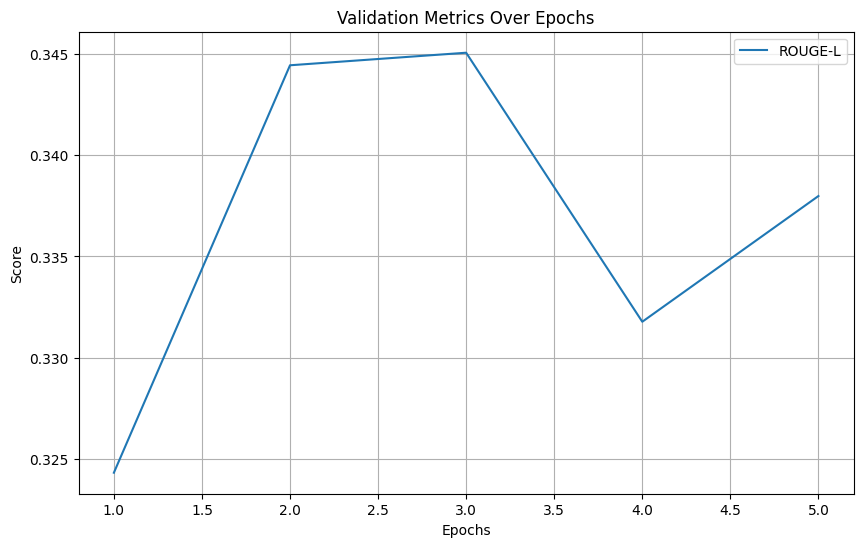

In [29]:
import matplotlib.pyplot as plt

# Plot training loss over epochs

plt.figure(figsize=(10, 6))
#plt.plot(range(1, epochs + 1), bleu_scores, label='BLEU')
#plt.plot(range(1, epochs + 1), rouge1_scores, label='ROUGE-1')
#plt.plot(range(1, epochs + 1), rouge2_scores, label='ROUGE-2')
plt.plot(range(1, 6), rougeL_scores, label='ROUGE-L')
#plt.plot(range(1, epochs + 1), meteor_scores, label='METEOR')
#plt.plot(range(1, epochs + 1), bert_f1_scores, label='BERT F1')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Validation Metrics Over Epochs')
plt.legend()
plt.grid()
plt.show()

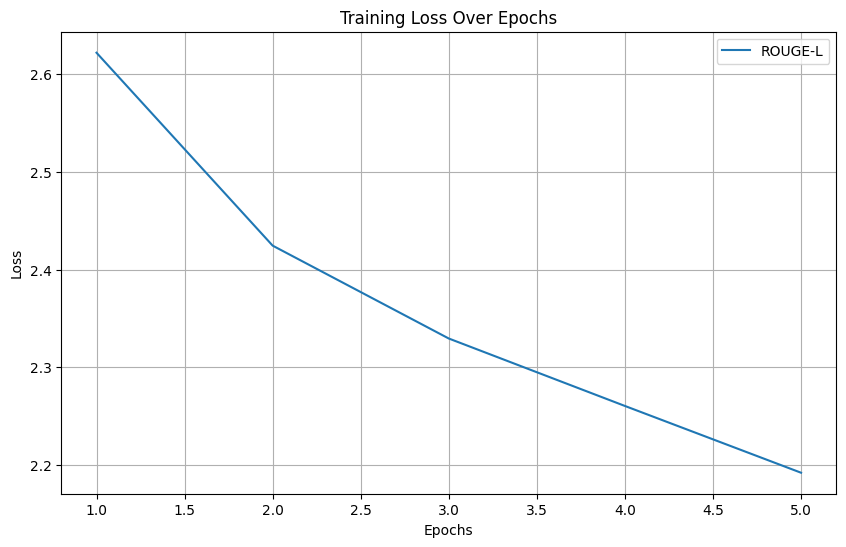

In [30]:
import matplotlib.pyplot as plt

# Plot training loss over epochs

plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), training_losses, label='ROUGE-L')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

In [31]:
import requests
import imageio
from PIL import Image
from io import BytesIO
import torch
from nltk.translate.bleu_score import corpus_bleu
from rouge_score import rouge_scorer
from bert_score import score as bert_score_fn
import torch.nn.functional as F

def process_and_evaluate_gif(
    gif_url,
    actual_description,
    blip_processor,
    blip_model,
    t5_tokenizer,
    t5_model,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    num_frames=5,
    frame_size=(256, 256),
    max_length=128,
    max_target_length=150,
    num_beams=4
):
    """
    Processes an unseen GIF to generate a description and evaluates it against the actual description.

    Args:
        gif_url (str): URL of the GIF to process.
        actual_description (str): The ground truth description of the GIF.
        blip_processor: BLIP processor instance.
        blip_model: Trained BLIP model instance.
        t5_tokenizer: T5 tokenizer instance.
        t5_model: Trained T5 model instance.
        device (str): Device to run the models on ('cuda' or 'cpu').
        num_frames (int): Number of frames to extract from the GIF.
        frame_size (tuple): Desired frame size (width, height).
        max_length (int): Maximum token length for T5 input.
        max_target_length (int): Maximum token length for T5 output.
        num_beams (int): Number of beams for beam search in T5 generation.

    Returns:
        dict: Evaluation metrics including BLEU, ROUGE-1, ROUGE-2, ROUGE-L, and BERT_F1.
    """
    # Step 1: Download the GIF
    try:
        response = requests.get(gif_url, timeout=10)
        response.raise_for_status()
        gif_bytes = BytesIO(response.content)
        print(f"Successfully downloaded GIF from {gif_url}")
    except requests.exceptions.RequestException as e:
        print(f"Failed to download GIF from {gif_url}: {e}")
        return None

    # Step 2: Extract frames from the GIF
    try:
        gif = imageio.mimread(gif_bytes, memtest=False)
        total_frames = len(gif)
        if total_frames == 0:
            print("No frames found in the GIF.")
            return None
        interval = max(total_frames // num_frames, 1)
        selected_frames = [gif[i] for i in range(0, total_frames, interval)][:num_frames]
        print(f"Extracted {len(selected_frames)} frames from the GIF.")
    except Exception as e:
        print(f"Error extracting frames from GIF: {e}")
        return None

    # Step 3: Ensure each GIF has exactly num_frames by padding if necessary
    while len(selected_frames) < num_frames:
        if selected_frames:
            selected_frames.append(selected_frames[-1])
        else:
            # Append a blank frame if no frames are extracted
            selected_frames.append(np.zeros((frame_size[1], frame_size[0], 3), dtype=np.uint8))
    selected_frames = selected_frames[:num_frames]  # Ensure no more than num_frames
    print(f"Total frames after padding: {len(selected_frames)}")

    # Step 4: Convert frames to PIL Images, resize, and generate captions using BLIP
    captions = []
    for idx, frame in enumerate(selected_frames):
        try:
            img = Image.fromarray(frame).convert('RGB')
            img_resized = img.resize(frame_size)
            inputs = blip_processor(img_resized, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = blip_model.generate(**inputs, max_length=50)
            caption = blip_processor.decode(outputs[0], skip_special_tokens=True)
            captions.append(caption)
            print(f"Frame {idx+1}: {caption}")
        except Exception as e:
            print(f"Failed to generate caption for frame {idx+1}: {e}")
            captions.append("")  # Append empty string for failed captions

    # Step 5: Concatenate captions to form T5 input
    concatenated_captions = " ".join(captions)
    print(f"Concatenated Captions: {concatenated_captions}")

    # Step 6: Tokenize the concatenated captions for T5
    try:
        encoding = t5_tokenizer.encode_plus(
            concatenated_captions,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        input_ids = encoding['input_ids'].to(device)
        attention_mask = encoding['attention_mask'].to(device)
    except Exception as e:
        print(f"Error during tokenization: {e}")
        return None

    # Step 7: Generate description using T5
    try:
        t5_model.eval()
        with torch.no_grad():
            outputs = t5_model.generate(
                input_ids=input_ids,
                attention_mask=attention_mask,
                max_length=max_target_length,
                num_beams=num_beams,
                early_stopping=True
            )
        generated_description = t5_tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(f"Generated Description: {generated_description}")
    except Exception as e:
        print(f"Error during T5 generation: {e}")
        return None

    # Step 8: Evaluate the generated description against the actual description
    scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2', 'rougeL'], use_stemmer=True)

    # Prepare tokenized inputs
    ref_tokens = actual_description.split()
    hyp_tokens = generated_description.split()

    # Calculate BLEU
    bleu = corpus_bleu([[ref_tokens]], [hyp_tokens])

    # Calculate ROUGE
    scores = scorer.score(actual_description, generated_description)
    rouge1 = scores['rouge1'].fmeasure
    rouge2 = scores['rouge2'].fmeasure
    rougeL = scores['rougeL'].fmeasure

    # Calculate BERT Score
    P, R, F1 = bert_score_fn(
        [' '.join(hyp_tokens)],
        [' '.join(ref_tokens)],
        lang='en',
        verbose=False
    )
    bert_f1 = F1.mean().item()

    # Compile metrics
    metrics = {
        'BLEU': bleu,
        'ROUGE-1': rouge1,
        'ROUGE-2': rouge2,
        'ROUGE-L': rougeL,
        'BERT_F1': bert_f1
    }

    # Display Metrics
    print("\nEvaluation Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

    return {
        'generated_description': generated_description,
        'actual_description': actual_description,
        'metrics': metrics
    }


In [32]:
# Example unseen GIF
unseen_gif = {
    'url': 'https://38.media.tumblr.com/f754d72da3c6a58211c760d39dff5be3/tumblr_n8vbphDLEh1qdzzbko1_250.gif',
    'actual_description': 'a man in a tuxedo stares as smoke rises next to him'
}

# Process and evaluate the unseen GIF
result = process_and_evaluate_gif(
    gif_url=unseen_gif['url'],
    actual_description=unseen_gif['actual_description'],
    blip_processor=blip_processor,
    blip_model=blip_model,
    t5_tokenizer=t5_tokenizer,
    t5_model=t5_model,
    device=device,
    num_frames=5,
    frame_size=(256, 256),
    max_length=128,
    max_target_length=150,
    num_beams=4
)

# Check the result
if result:
    print("\nFinal Results:")
    print(f"Generated Description: {result['generated_description']}")
    print(f"Actual Description: {result['actual_description']}")
    print("Evaluation Metrics:")
    for metric, score in result['metrics'].items():
        print(f"  {metric}: {score:.4f}")
else:
    print("Processing and evaluation failed.")


Successfully downloaded GIF from https://38.media.tumblr.com/f754d72da3c6a58211c760d39dff5be3/tumblr_n8vbphDLEh1qdzzbko1_250.gif
Extracted 5 frames from the GIF.
Total frames after padding: 5
Frame 1: a man in a tuxed suit and bow tie
Frame 2: a man in a tuxed suit and bow tie
Frame 3: a man in a tuxed suit and bow tie
Frame 4: a man in a tuxed suit and bow tie
Frame 5: a man in a tuxed suit and bow tie
Concatenated Captions: a man in a tuxed suit and bow tie a man in a tuxed suit and bow tie a man in a tuxed suit and bow tie a man in a tuxed suit and bow tie a man in a tuxed suit and bow tie
Generated Description: a man in a tuxedo wears a tuxedo with a hooded shirt.


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Evaluation Metrics:
BLEU: 0.3170
ROUGE-1: 0.4167
ROUGE-2: 0.3636
ROUGE-L: 0.4167
BERT_F1: 0.9107

Final Results:
Generated Description: a man in a tuxedo wears a tuxedo with a hooded shirt.
Actual Description: a man in a tuxedo stares as smoke rises next to him
Evaluation Metrics:
  BLEU: 0.3170
  ROUGE-1: 0.4167
  ROUGE-2: 0.3636
  ROUGE-L: 0.4167
  BERT_F1: 0.9107
